In [1]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
from keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib

dataset_url = "https://download1979.mediafire.com/7a55s1jr47pgdFgBAZbThWYIsXFhJp-SNxmYY7xRdS5Iqm_e7fSQfoOjJ0KSSSHMS5VCqJfwv35ViKdMfm2-YJZ1uDIhpz1INsDj0IPh22wbgGv0C1jKqS6C9GURDkD_3QqFCl8FoRgVy00AwIANOdLh_ITTKu9Rp1Kop2rg/481hkbka750brv8/data_khdl.tgz"
    # Download and extract the dataset
archive_path = tf.keras.utils.get_file(origin=dataset_url, extract=True)
archive_path = pathlib.Path(archive_path).with_suffix('')



995195096/995195096 [==============================] - 18s 0us/step


## <a id='step21'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 2.1 | <b></span><span style="color:#368F8B"><b>Import Data</b></span></span>

In [5]:
base_dir = '/root/.keras/datasets/Flower Classification V2/V2'

In [6]:
train_dir = os.path.join(base_dir, 'Training Data')
validation_dir = os.path.join(base_dir, 'Validation Data')
test_dir = os.path.join(base_dir, 'Testing Data')

## <a id='step22'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 2.2 | <b></span><span style="color:#368F8B"><b>Count data and classes</b></span></span>

In [7]:
def num_of_classes(folder_dir, folder_name) :
    classes = [class_name for class_name in os.listdir(train_dir)]
    print(colored(f'number of classes in {folder_name} folder : {len(classes)}', 'blue', attrs=['bold']))

In [8]:
num_of_classes(train_dir, 'train')
num_of_classes(validation_dir, 'validation')
num_of_classes(test_dir, 'test')

number of classes in train folder : 10
number of classes in validation folder : 10
number of classes in test folder : 10


In [ ]:
# work on train folder and count number of samples per each class

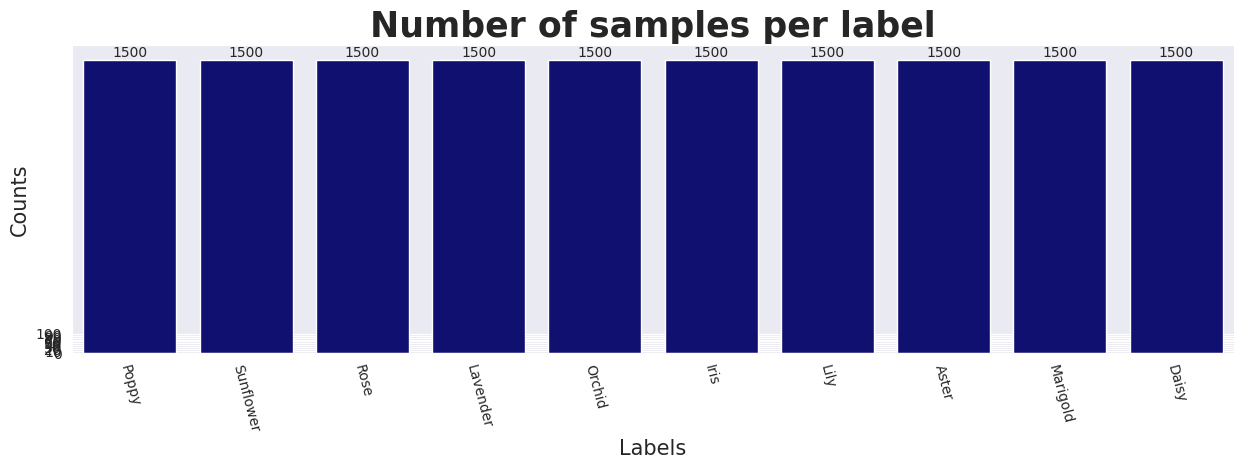

In [9]:
classes = [class_name for class_name in os.listdir(train_dir)]
count = []
for class_name in classes :
    count.append(len(os.listdir(os.path.join(train_dir, class_name))))

plt.figure(figsize=(15, 4))
ax = sns.barplot(x=classes, y=count, color='navy')
plt.xticks(rotation=285)
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Number of samples per label', fontsize=25, fontweight='bold')
plt.xlabel('Labels', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.yticks(np.arange(0, 105, 10))
plt.show()

## <a id='step23'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 2.3 | <b></span><span style="color:#368F8B"><b>Convert data to a DataFrame</b></span></span>

In [10]:
# A function to return DataFrame

def create_df(folder_path) :
    all_images = []
    for class_name in classes :
        class_path = os.path.join(folder_path, class_name)
        all_images.extend([(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)])
    df = pd.DataFrame(all_images, columns=['file_path', 'label'])
    return df

In [11]:
train_df = create_df(train_dir)
validation_df = create_df(validation_dir)
test_df = create_df(test_dir)

In [12]:
print(colored(f'Number of samples in train : {len(train_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples in validation : {len(validation_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples test : {len(test_df)}', 'blue', attrs=['bold']))

Number of samples in train : 15000
Number of samples in validation : 5000
Number of samples test : 2355


# Show an image per each class(label)

## <a id='step24'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 2.4 | <b></span><span style="color:#368F8B"><b>Show an image per each class(label)</b></span></span>

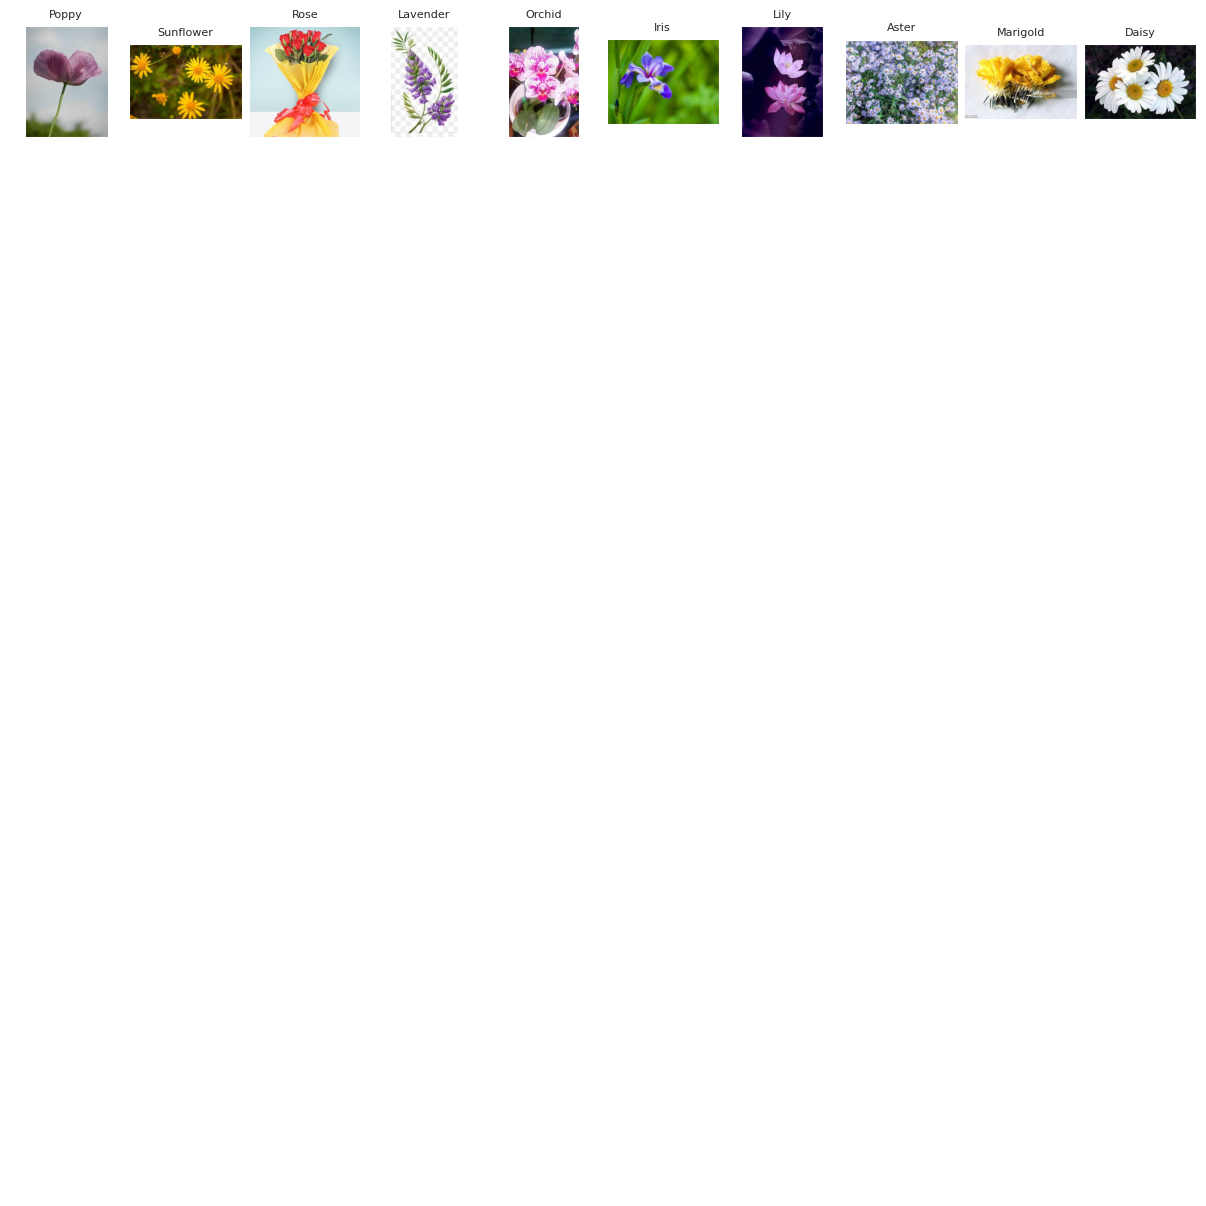

In [13]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["label"]).reset_index()

# Determine the number of unique labels
num_labels = len(df_unique)

# Set up the number of rows and columns for the subplot grid
nrows, ncols = 10, 10

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12),
                         subplot_kw={'xticks': [], 'yticks': []})

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each image
for i, ax in enumerate(axes[:min(num_labels, nrows*ncols)]):
    image_path = df_unique.file_path.iloc[i]
    label = df_unique.label.iloc[i]
    try:
        img = plt.imread(image_path)
        ax.imshow(img)
        ax.set_title(label, fontsize=8)  # Adjust font size for smaller subplots
    except FileNotFoundError:
        ax.set_title(f"File not found: {label}", fontsize=8)

# Hide any unused subplots
for ax in axes[min(num_labels, nrows*ncols):]:
    ax.axis('off')

plt.tight_layout(pad=0.5)
plt.show()

## <a id='step25'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 2.5 | <b></span><span style="color:#368F8B"><b>Data generators</b></span></span>

Because of having less samples in each category, we use data generator and data augmentation to avoid over fitting and achive better performance.

In [52]:
# Train generator

train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Scaled images in range 0 to 1
    rotation_range=20,              # Rorate images by factor 20 degree
    width_shift_range=0.2,          # Shift images horizontally by up to 20% of their width
    height_shift_range=0.2,         # Shift images vertically by up to 20% of their width
    zoom_range=0.1,                 # Zoom in and out images by 10%
    horizontal_flip=True,           # Allow horizontal flipping
    shear_range=0.1,                # shear images by 10% their size
    fill_mode='nearest',            # fill unlocated pixels by nearest pixel
    )

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,             # Target data
    x_col='file_path',              # X column
    y_col='label',                  # y column
    target_size=(224, 224),         # Resize images  to
    color_mode='rgb',               # Color mode
    class_mode='categorical',       # type of model
    batch_size=32,
    shuffle=True,
    seed=42,

)

Found 15000 validated image filenames belonging to 10 classes.


In [64]:
# Truy cập và in ra các nhãn
class_indices = train_generator.class_indices
indices_to_labels = {v: k for k, v in class_indices.items()}

print("Các nhãn lớp:")
for index in sorted(indices_to_labels):
    print(f"Chỉ số lớp {index}: {indices_to_labels[index]}")

Các nhãn lớp:
Chỉ số lớp 0: Aster
Chỉ số lớp 1: Daisy
Chỉ số lớp 2: Iris
Chỉ số lớp 3: Lavender
Chỉ số lớp 4: Lily
Chỉ số lớp 5: Marigold
Chỉ số lớp 6: Orchid
Chỉ số lớp 7: Poppy
Chỉ số lớp 8: Rose
Chỉ số lớp 9: Sunflower


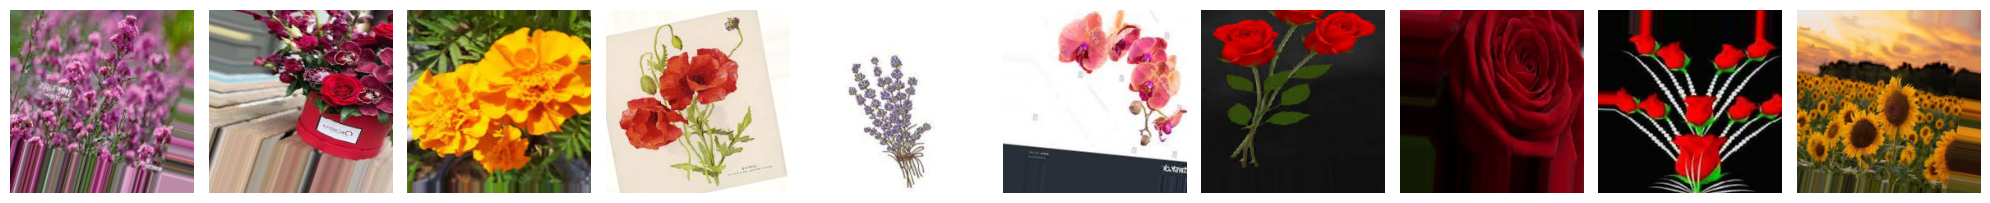

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot images
def plot_images(images_arr):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Get a batch of images and labels from the generator
images, labels = next(train_generator)

# Display the first 5 images from the batch
plot_images(images[:10])

Found 5000 validated image filenames belonging to 10 classes.


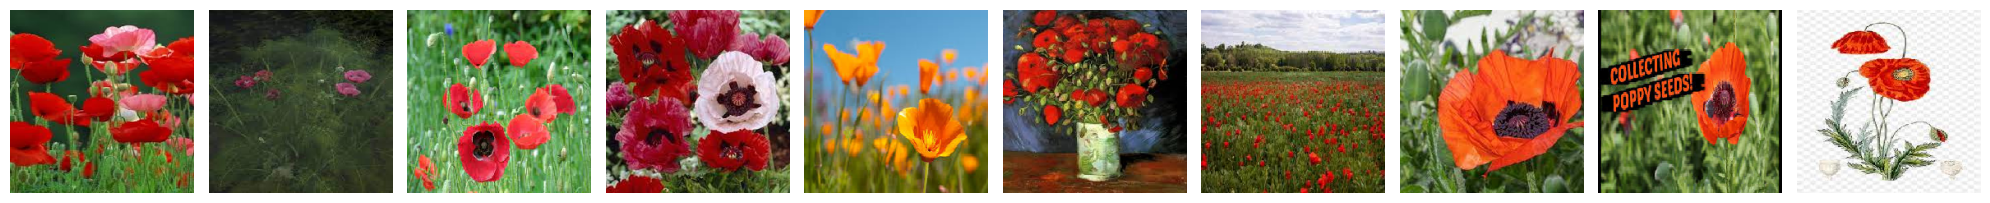

In [16]:
# validation generator

validation_datagen = ImageDataGenerator(rescale=1./255,)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=False
)
# Get a batch of images and labels from the generator
images, labels = next(validation_generator)

# Display the first 5 images from the batch
plot_images(images[:10])

Found 2355 validated image filenames belonging to 10 classes.


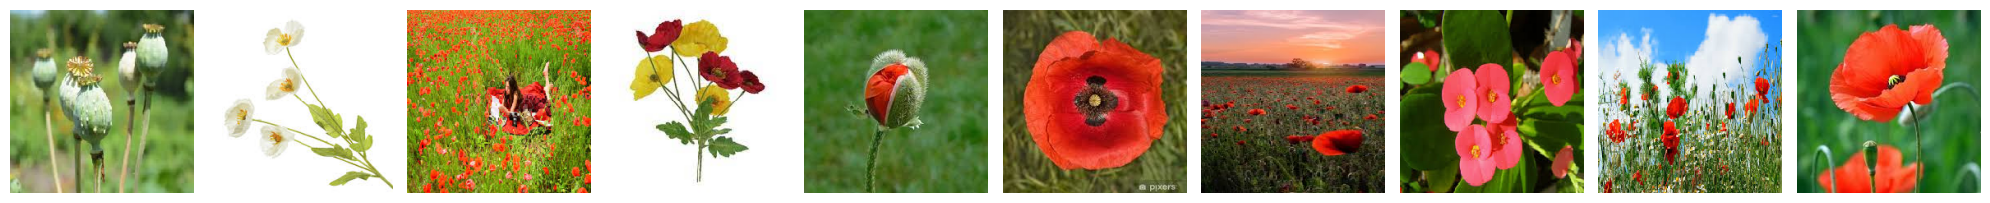

In [17]:
# Test generator

test_datagen = ImageDataGenerator(rescale=1./255,)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=False
)
# Get a batch of images and labels from the generator
images, labels = next(test_generator)

# Display the first 5 images from the batch
plot_images(images[:10])

# <a id='step3'></a>
# <div style="background-color:#012622;background-size: cover;font-family:tahoma;font-size:200%;text-align:center;border-radius:25px 25px 25px 25px; padding:10px; border:solid 2px #09375b"><span style="color:red"><b>Step 3 | <b></span><span style="color:white"><b>Modeling</b></span></div>

##### [🏠 Tabel of Contents](#content)

## <a id='step31'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 3.1 | <b></span><span style="color:#368F8B"><b>Add MobileNetV2 model</b></span></span>

In [66]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, BatchNormalization, ReLU, Add, Input, GlobalAveragePooling2D, Dense, ZeroPadding2D
from tensorflow.keras.models import Model

def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

def inverted_res_block(inputs, expansion, stride, alpha, filters, block_id):
    in_channels = inputs.shape[-1]
    pointwise_filters = _make_divisible(int(filters * alpha), 8)
    x = inputs
    if block_id == 0:
        prefix = 'expanded_conv_'
    else:
        prefix = f'block_{block_id}_'

    if block_id:
        # Expand
        x = Conv2D(expansion * in_channels, kernel_size=1, padding='same', use_bias=False, name=prefix + 'expand')(x)
        x = BatchNormalization(name=prefix + 'expand_BN')(x)
        x = ReLU(6., name=prefix + 'expand_relu')(x)


    x = DepthwiseConv2D(kernel_size=3, strides=stride, activation=None, use_bias=False, padding='same' if stride == 1 else 'valid', name=prefix + 'depthwise')(x)
    x = BatchNormalization(name=prefix + 'depthwise_BN')(x)
    x = ReLU(6., name=prefix + 'depthwise_relu')(x)

    # Project
    x = Conv2D(pointwise_filters, kernel_size=1, padding='same', use_bias=False, activation=None, name=prefix + 'project')(x)
    x = BatchNormalization(name=prefix + 'project_BN')(x)

    if in_channels == pointwise_filters and stride == 1:
        x = Add(name=prefix + 'add')([inputs, x])

    return x

def MobileNetV2(input_shape=(224, 224, 3), num_classes=1000, alpha=1.0):
    inputs = Input(shape=input_shape)
    first_block_filters = _make_divisible(32 * alpha, 8)
    x = ZeroPadding2D(padding=((0, 1), (0, 1)), name='Conv1_pad')(inputs)
    x = Conv2D(first_block_filters, kernel_size=3, strides=(2, 2), padding='valid', use_bias=False, name='Conv1')(x)
    x = BatchNormalization(name='bn_Conv1')(x)
    x = ReLU(6., name='Conv1_relu')(x)

    x = inverted_res_block(x, filters=16, alpha=alpha, stride=1, expansion=1, block_id=0)

    x = inverted_res_block(x, filters=24, alpha=alpha, stride=2, expansion=6, block_id=1)
    x = inverted_res_block(x, filters=24, alpha=alpha, stride=1, expansion=6, block_id=2)

    x = inverted_res_block(x, filters=32, alpha=alpha, stride=2, expansion=6, block_id=3)
    x = inverted_res_block(x, filters=32, alpha=alpha, stride=1, expansion=6, block_id=4)
    x = inverted_res_block(x, filters=32, alpha=alpha, stride=1, expansion=6, block_id=5)

    x = inverted_res_block(x, filters=64, alpha=alpha, stride=2, expansion=6, block_id=6)
    x = inverted_res_block(x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=7)
    x = inverted_res_block(x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=8)
    x = inverted_res_block(x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=9)

    x = inverted_res_block(x, filters=96, alpha=alpha, stride=1, expansion=6, block_id=10)
    x = inverted_res_block(x, filters=96, alpha=alpha, stride=1, expansion=6, block_id=11)
    x = inverted_res_block(x, filters=96, alpha=alpha, stride=1, expansion=6, block_id=12)

    x = inverted_res_block(x, filters=160, alpha=alpha, stride=2, expansion=6, block_id=13)
    x = inverted_res_block(x, filters=160, alpha=alpha, stride=1, expansion=6, block_id=14)
    x = inverted_res_block(x, filters=160, alpha=alpha, stride=1, expansion=6, block_id=15)

    x = inverted_res_block(x, filters=320, alpha=alpha, stride=1, expansion=6, block_id=16)

    last_block_filters = _make_divisible(1280 * alpha, 8)
    x = Conv2D(last_block_filters, kernel_size=1, use_bias=False, name='Conv_1')(x)
    x = BatchNormalization(name='Conv_1_bn')(x)
    x = ReLU(6., name='out_relu')(x)

    x = GlobalAveragePooling2D()(x)


    model = Model(inputs, x, name='mobilenetv2_%0.2f_%s' % (alpha, input_shape[0]))

    return model

# Example usage
pre_trained_model = MobileNetV2(input_shape=(224, 224, 3), num_classes=10, alpha=1.0)
pre_trained_model.summary()


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1_pad (ZeroPadding2D)   (None, 225, 225, 3)          0         ['input_5[0][0]']             
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['Conv1_pad[0][0]']           
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                           

## <a id='step32'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 3.2 | <b></span><span style="color:#368F8B"><b>Freeze MobileNetV2 layers</b></span></span>

In [19]:
# Name of layers in MobileNetV2
for layer in pre_trained_model.layers :
    print(layer.name)

input_1
Conv1_pad
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
block_5_add
block_6_expand
block_6_expand_BN
block_6_ex

In [67]:
# Freeze all layers, except last layer
# The goal is to train just last layer of pre trained model

pre_trained_model.trainable = True
set_trainable = False

for layer in pre_trained_model.layers :
    if layer.name == 'block_16_expand' :
        set_trainable = True
    if set_trainable :
        layer.trainable = True
    else :
        layer.trainable = False

## <a id='step33'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 3.3 | <b></span><span style="color:#368F8B"><b>Define a model</b></span></span>

In [68]:
# Add custom layers on top of the base model
model = models.Sequential()
model.add(pre_trained_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

## <a id='step34'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 3.4 | <b></span><span style="color:#368F8B"><b>Model Diagram</b></span></span>

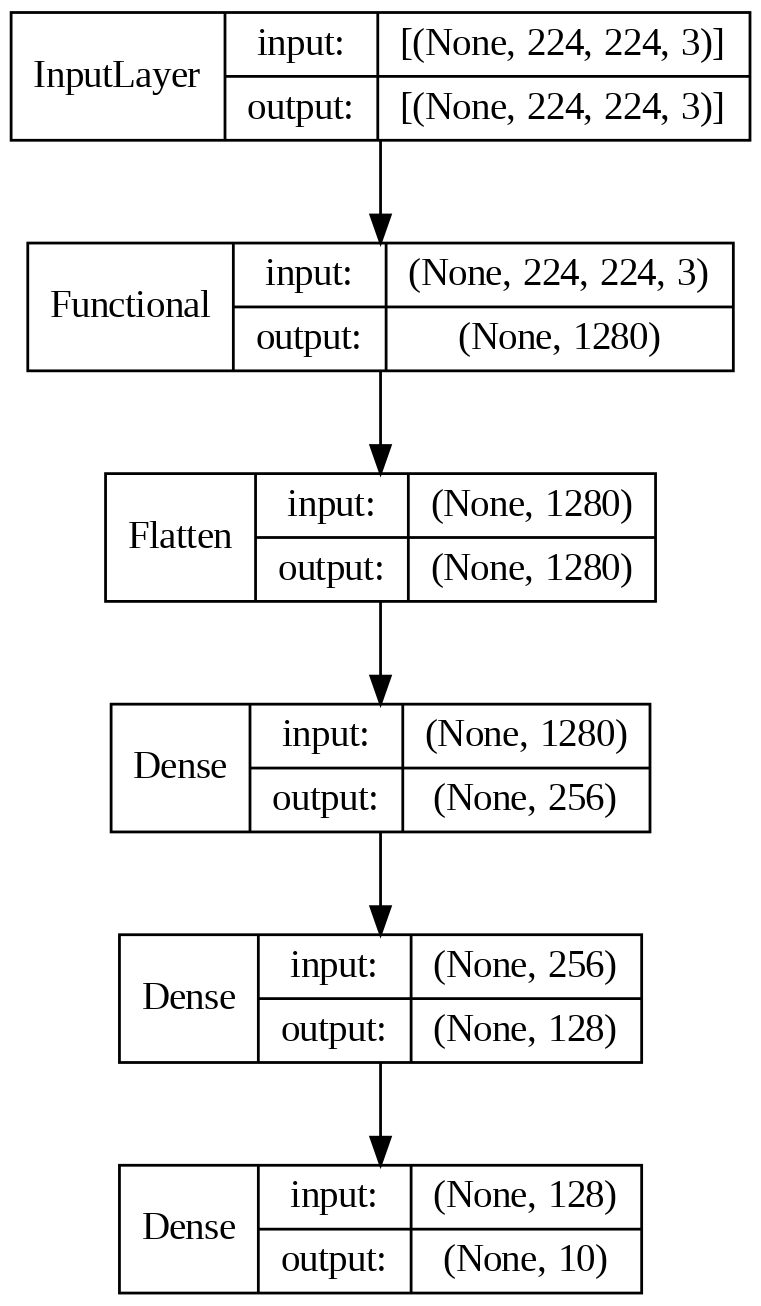

In [40]:
plot_model(model, show_shapes=True, show_layer_names=False, dpi=200)

In [41]:
# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               327936    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 2620106 (9.99 MB)
Trainable params: 1248202 (4.76 MB)
Non-trainable params: 1371904 (5.23 MB)
____________

## <a id='step35'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 3.5 | <b></span><span style="color:#368F8B"><b>Compile Model</b></span></span>

In [69]:
# Compile
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

## <a id='step36'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 3.6 | <b></span><span style="color:#368F8B"><b>CallBacks</b></span></span>

In [70]:
# Model CheckPoint
checkpoint_save_path = '/content/drive/MyDrive/DataScience/save_weights/New_mobilenetv2.ckpt'
if os.path.exists(checkpoint_save_path + '.index'):
    print('-----------------------loading-----------------------')
    model.load_weights(checkpoint_save_path)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path, save_best_only=True, save_weights_only=True)

# Early Stoping
earlystop_cb = EarlyStopping(patience=10, restore_best_weights=True)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

-----------------------loading-----------------------


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## <a id='step37'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 3.7 | <b></span><span style="color:#368F8B"><b>Train Model</b></span></span>

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr]
)

Epoch 1/100
469/469 [==============================] - 215s 440ms/step - loss: 0.8838 - accuracy: 0.7248 - val_loss: 2.3628 - val_accuracy: 0.6002 - lr: 0.0010
Epoch 2/100
469/469 [==============================] - 202s 430ms/step - loss: 0.6354 - accuracy: 0.8045 - val_loss: 3.1789 - val_accuracy: 0.5686 - lr: 0.0010
Epoch 3/100
469/469 [==============================] - 203s 432ms/step - loss: 0.5558 - accuracy: 0.8275 - val_loss: 1.9030 - val_accuracy: 0.6982 - lr: 0.0010
Epoch 4/100
469/469 [==============================] - 205s 436ms/step - loss: 0.4991 - accuracy: 0.8407 - val_loss: 1.3411 - val_accuracy: 0.7764 - lr: 0.0010
Epoch 5/100
469/469 [==============================] - 198s 423ms/step - loss: 0.4515 - accuracy: 0.8606 - val_loss: 1.2399 - val_accuracy: 0.8126 - lr: 0.0010
Epoch 6/100
469/469 [==============================] - 201s 429ms/step - loss: 0.4119 - accuracy: 0.8707 - val_loss: 1.0013 - val_accuracy: 0.8286 - lr: 0.0010
Epoch 7/100
469/469 [===================

In [ ]:
model.save_weights('/content/drive/MyDrive/save_weights/MonbilenetV2.ckpt')

## <a id='step38'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 3.8 | <b></span><span style="color:#368F8B"><b>Plot the result of training</b></span></span>

In [ ]:
# Convert resutl of training to a DataFrame
result_df = pd.DataFrame(history.history)
result_df.tail()

,loss,accuracy,val_loss,val_accuracy,lr
21,0.104460,0.964733,0.613716,0.8742,0.000250
22,0.085634,0.971133,0.604235,0.8800,0.000125
23,0.077469,0.973667,0.650716,0.8738,0.000125
24,0.075678,0.974733,0.651850,0.8782,0.000125
25,0.064836,0.977400,0.657215,0.8774,0.000063


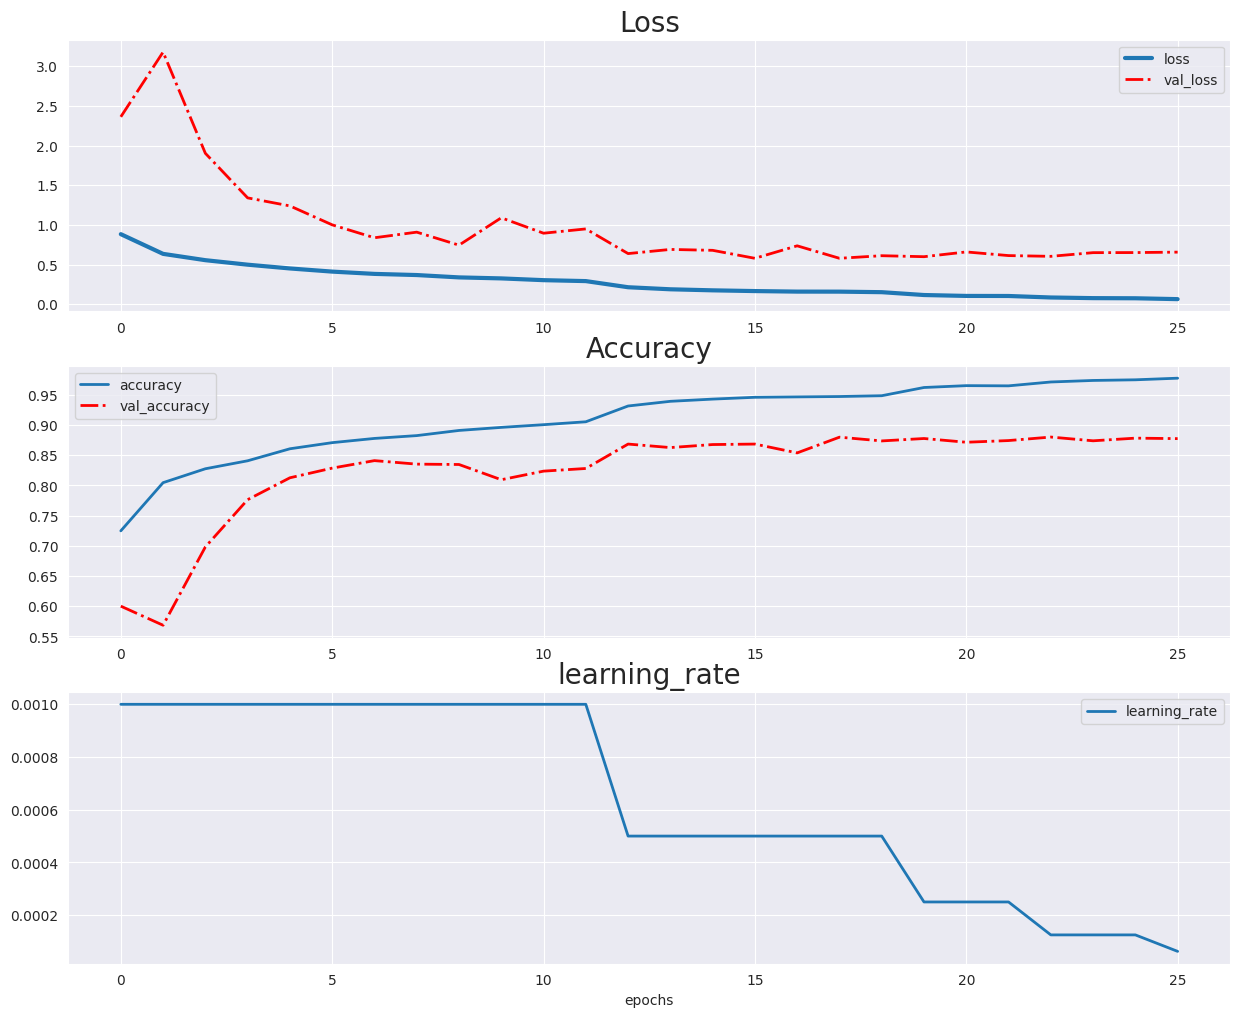

In [ ]:
x = np.arange(len(result_df))
fig, ax = plt.subplots(3, 1, figsize=(15, 12))
#  AX0 : Loss
ax[0].plot(x, result_df.loss, label='loss', linewidth=3)
ax[0].plot(x, result_df.val_loss, label='val_loss', linewidth=2, ls='-.', c='r')
ax[0].set_title('Loss', fontsize=20)
ax[0].legend()

#  AX1 : Loss
ax[1].plot(x, result_df.accuracy, label='accuracy', linewidth=2)
ax[1].plot(x, result_df.val_accuracy, label='val_accuracy', linewidth=2, ls='-.', c='r')
ax[1].set_title('Accuracy', fontsize=20)
ax[1].legend()

#  AX2 : Loss
ax[2].plot(x, result_df.lr, label='learning_rate', linewidth=2)
ax[2].set_title('learning_rate', fontsize=20)
ax[2].set_xlabel('epochs')
ax[2].legend()


plt.sharex=True


plt.show()

## <a id='step39'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>Step 3.9 | <b></span><span style="color:#368F8B"><b>Evaluate the Model</b></span></span>

In [61]:
# checkpoint callback, save base model weights in "MyModel.keras".
# So, we should load it
model.load_weights(checkpoint_save_path)

In [62]:
# Đánh giá mô hình trên tập kiểm tra
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy:.4f}')

74/74 [==============================] - 6s 65ms/step - loss: 0.6906 - accuracy: 0.8599
Test accuracy: 0.8599


In [29]:
def evaluate_model_performance(model, val_generator, class_labels):
    """
    Evaluate the model's performance on the validation set and print the classification report.

    Parameters:
    - model: The trained model.
    - val_generator: Validation data generator.
    - class_labels: List of class names.

    Returns:
    - report: Classification report as a string.
    """

    # Getting all the true labels for the validation set
    true_labels = val_generator.classes

    # Get the class labels (names) from the generator
    class_labels = list(val_generator.class_indices.keys())

    # To get the predicted labels, we predict using the model
    predictions = model.predict(val_generator, steps=len(val_generator))

    # Take the argmax to get the predicted class indices.
    predicted_labels = np.argmax(predictions, axis=1)

    # Extracting true labels from the validation generator
    true_labels = val_generator.classes

    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')

    # Define a custom colormap
    colors = ["white", "#102C42"]
    # cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plotting confusion matrix using seaborn
    plt.figure(figsize=(15,10))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

74/74 [==============================] - 6s 71ms/step
              precision    recall  f1-score   support

       Aster       0.68      0.86      0.76       146
       Daisy       0.90      0.68      0.77       260
        Iris       0.94      0.81      0.87       317
    Lavender       0.83      0.94      0.88       217
        Lily       0.84      0.91      0.87       350
    Marigold       0.73      0.94      0.82       108
      Orchid       0.85      0.74      0.79       202
       Poppy       0.86      0.89      0.87       158
        Rose       0.91      0.90      0.91       269
   Sunflower       0.93      0.95      0.94       328

    accuracy                           0.86      2355
   macro avg       0.85      0.86      0.85      2355
weighted avg       0.87      0.86      0.86      2355





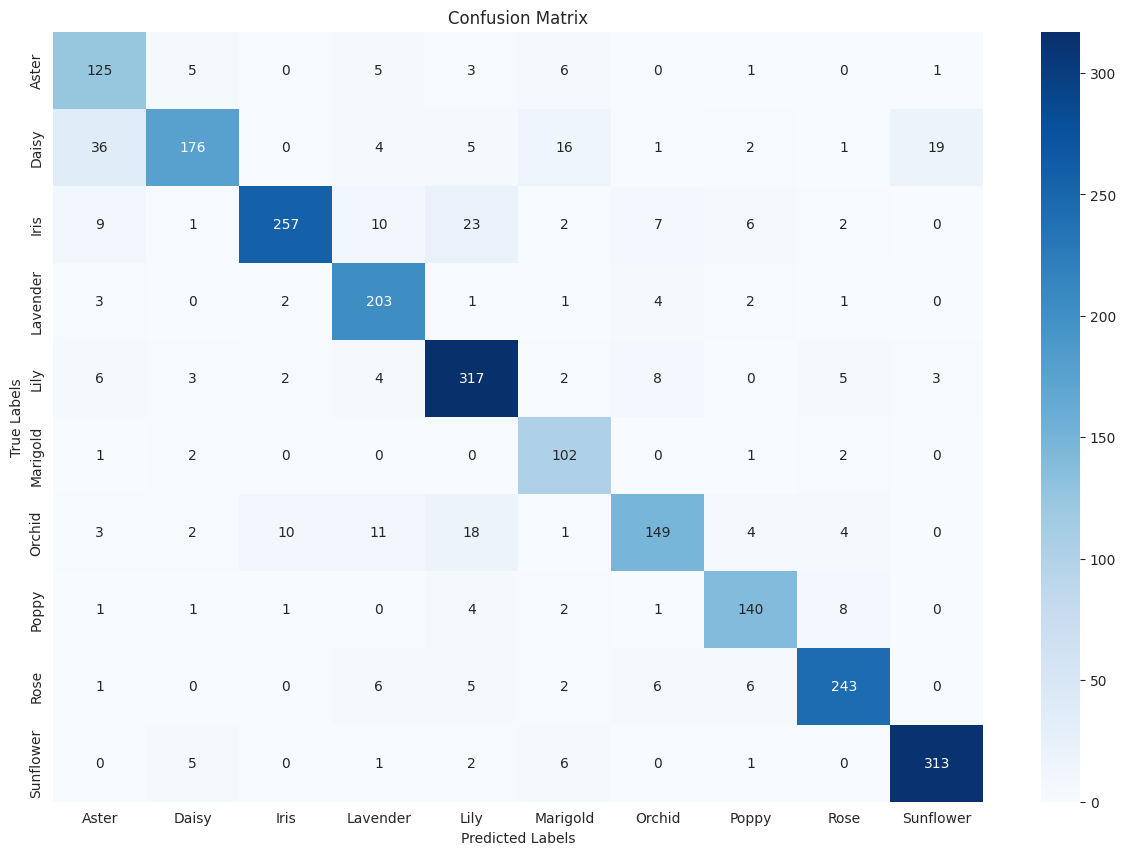

In [60]:
evaluate_model_performance(model, test_generator, classes)

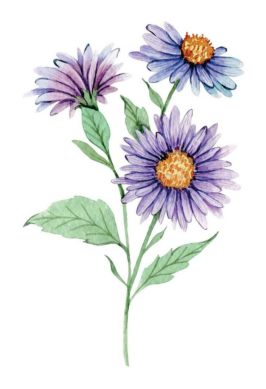

1/1 [==============================] - 0s 57ms/step
Aster: 97.08%
Daisy: 2.79%
Iris: 0.00%
Lavender: 0.00%
Lily: 0.01%
Marigold: 0.10%
Orchid: 0.01%
Poppy: 0.00%
Rose: 0.00%
Sunflower: 0.01%
Lớp dự đoán: Aster (97.08%)


In [76]:
import requests
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

# Tải ảnh từ internet
url = 'https://static.vecteezy.com/system/resources/previews/032/042/221/non_2x/aster-watercolor-illustration-aster-flower-isolated-on-white-september-birth-month-flower-aster-hand-painted-watercolor-botanical-illustration-vector.jpg'  # Thay thế bằng URL của bạn
response = requests.get(url)
img = Image.open(BytesIO(response.content))

# Chuyển đổi ảnh sang RGB (nếu chưa phải là RGB)
if img.mode != 'RGB':
    img = img.convert('RGB')

# Hiển thị ảnh
plt.imshow(img)
plt.axis('off')
plt.show()

# Tiền xử lý ảnh
img = img.resize((224, 224))  # Thay đổi kích thước ảnh
img_array = img_to_array(img)  # Chuyển đổi ảnh thành mảng
img_array = np.expand_dims(img_array, axis=0)  # Thêm chiều batch
img_array = preprocess_input(img_array)  # Tiền xử lý ảnh cho MobileNetV2

# Sử dụng mô hình tùy chỉnh của bạn để dự đoán

predictions = model.predict(img_array)

# Nhãn lớp cho mô hình của bạn
class_labels = ['Aster', 'Daisy', 'Iris', 'Lavender', 'Lily', 'Marigold', 'Orchid', 'Poppy', 'Rose', 'Sunflower']  # Thay thế bằng nhãn lớp của bạn

# In ra xác suất dự đoán cho từng lớp
for i, class_label in enumerate(class_labels):
    print(f"{class_label}: {predictions[0][i] * 100:.2f}%")

# Xác định lớp dự đoán
predicted_class_index = np.argmax(predictions[0])
predicted_class_label = class_labels[predicted_class_index]
predicted_class_score = predictions[0][predicted_class_index]

# In ra lớp dự đoán
print(f"Lớp dự đoán: {predicted_class_label} ({predicted_class_score * 100:.2f}%)")
